# Libraries

In [448]:
import numpy as np
import matplotlib.pyplot as plt

# Material Properties

In [449]:
elastic_modulus = 1e9
v = 0.3

# Quadrature Points

In [450]:
quad_points = np.array([[1/np.sqrt(3), 1/np.sqrt(3)], [-1/np.sqrt(3), 1/np.sqrt(3)], [-1/np.sqrt(3), -1/np.sqrt(3)], [1/np.sqrt(3), -1/np.sqrt(3)]])
w = np.array([1,1,1,1])

# Shape Functions

In [451]:
def evaluate_N(xi, eta):
    n = np.zeros(4)
    n[0] = (1+xi)*(1+eta)/4
    n[1] = (1-xi)*(1+eta)/4
    n[2] = (1-xi)*(1-eta)/4
    n[3] = (1+xi)*(1-eta)/4
    return n

def evaluate_dN_d_xi(xi, eta):
    v = np.zeros(4)
    v[0] = (1+eta)/4
    v[1] = (-1-eta)/4
    v[2] = (-1+eta)/4
    v[3] = (1-eta)/4
    return v

def evaluate_dN_d_eta(xi, eta):
    v = np.zeros(4)
    v[0] = (1+xi)/4
    v[1] = (1-xi)/4
    v[2] = (-1+xi)/4
    v[3] = (-1-xi)/4
    return v

In [452]:
n_quad = len(quad_points)
N = np.zeros([n_quad, 4])
dN_d_xi = np.zeros([n_quad, 4])
dN_d_eta = np.zeros([n_quad, 4])
for i in range(n_quad):
    xi = quad_points[i][0]
    eta = quad_points[i][1]
    N[i] = evaluate_N(xi,eta)
    dN_d_xi[i] = evaluate_dN_d_xi(xi,eta)
    dN_d_eta[i] = evaluate_dN_d_eta(xi,eta)

# Node Class

In [453]:
class Node:
    def __init__(self, id, x, y, ux=None, uy=None, rx=0, ry=0):
        self.id = id
        self.x  = x
        self.y  = y
        self.ux  = ux
        self.uy  = uy
        self.rx  = rx
        self.ry  = ry
    
    def __repr__(self):
        return f"Node({self.id}, x={self.x}, y={self.y}, ux={self.ux}, uy={self.uy}, rx={self.rx}, ry={self.ry})"

# Element Class

In [454]:
class Element:
    def __init__(self, id, nodes):
        self.id = id
        self.nodes = nodes

    def __repr__(self):
        node_ids = [node.id for node in self.nodes]  
        return f"Element(id={self.id}, nodes={node_ids})"
    
    def coordinates(self):
        return np.array([(node.x, node.y) for node in self.nodes])
    
    def compute_E(self):
        E = np.zeros([3,3])
        E[0][0] = 1-v
        E[0][1] = v
        E[0][2] = 0
        E[1][0] = v
        E[1][1] = 1-v
        E[0][2] = 0
        E[2][0] = 0
        E[2][1] = 0
        E[2][2] = (1-2*v)/2
        E = E * elastic_modulus / ((1+v)*(1-2*v))
        return E

    def compute_J(self, i_quad):
        #define jacobian matrix at quadrature point i, j
        j = np.zeros([2,2])
        #get coordinates of the nodes 
        coords = self.coordinates()
        x = coords[:,0]
        y = coords[:,1]
        #compute jacobian matrix elements
        j[0][0] = np.dot(x, dN_d_xi[i_quad])
        j[0][1] = np.dot(y, dN_d_xi[i_quad])
        j[1][0] = np.dot(x, dN_d_eta[i_quad])
        j[1][1] = np.dot(y, dN_d_eta[i_quad])
        return j

    def compute_B(self, i_quad, J_inv):
        dN = np.zeros([4,2]) #derivative matrix, size = n_shape * n_dims
        for i in range(4): #loop over shape functions
            mat = np.array([dN_d_xi[i_quad][i], dN_d_eta[i_quad][i]])
            dN[i] = np.matmul(J_inv, mat)
        B = np.zeros([3,8])
        B[0][0] = dN[0][0]
        B[0][2] = dN[1][0]
        B[0][4] = dN[2][0]
        B[0][6] = dN[3][0]
        B[1][1] = dN[0][1]
        B[1][3] = dN[1][1]
        B[1][5] = dN[2][1]
        B[1][7] = dN[3][1]
        B[2][0] = dN[0][1]
        B[2][1] = dN[0][0]
        B[2][2] = dN[1][1]
        B[2][3] = dN[1][0]
        B[2][4] = dN[2][1]
        B[2][5] = dN[2][0]
        B[2][6] = dN[3][1]
        B[2][7] = dN[3][0]
        return B
    
    def localStiffnessMatrix(self):
        k = 0
        E = self.compute_E()
        for i in range(n_quad):
            J = self.compute_J(i)
            J_inv = np.linalg.inv(J)
            det_J = np.linalg.det(J)
            B = self.compute_B(i, J_inv)
            BT = np.transpose(B)
            k += BT @ E @ B * det_J * w[i]
        return k
    

# Mesh class

In [455]:
class Mesh:
    def read_node_list(self, file_path):
        nodes = []
        node_section = False  # Flag to check if we are in the *Node section
        with open(file_path, 'r') as file:
            for line in file:
                line = line.strip()
                # Check for the start of the *Node section
                if line.startswith('*Node'):
                    node_section = True
                    continue  # Skip the line that contains *Node header
                # Start of element section, stop reading node
                if node_section and line.startswith('*Element'): 
                    node_section = False
                    break
                # Skip the line if it is not a node data line
                if not line or line.startswith('*') or not line[0].isdigit():
                    continue
                # If we are in the *Node section, process the node data
                node_data = line.split(',')
                node_id = int(node_data[0].strip())
                x = float(node_data[1].strip())
                y = float(node_data[2].strip())
                # Create Node object and append to the list
                node = Node(node_id, x, y)
                nodes.append(node)
        return nodes
    
    def read_element_list(self, file_path):
        elements = []
        element_section = False  # Flag to check if we are in the *Element section
        with open(file_path, 'r') as file:
            for line in file:
                line = line.strip()
                # Check for the start of the *Element section
                if line.startswith('*Element'):
                    element_section = True
                    continue  # Skip the line that contains *Element header
                # Stop reading elements
                if element_section and line.startswith('*Nset'): 
                    element_section = False
                    break
                # Skip the line if it is not an element data line
                if not line or line.startswith('*') or not line[0].isdigit() or not element_section:
                    continue
                # If we are in the *Element section, process the element data
                element_data = line.split(',')
                element_id = int(element_data[0].strip())
                nodes = []
                for i in range(1,5):
                    node_id = int(element_data[i].strip())
                    node_index = node_id - 1 #zero indexing shift
                    nodes.append(self.nodes[node_index]) 
                # Create Element object and append to the list
                element = Element(element_id, nodes)
                elements.append(element)
        return elements
    
    def __init__(self, file_path):
        self.nodes = self.read_node_list(file_path)
        self.elements = self.read_element_list(file_path)
    
    def plot_mesh(mesh, display_temp=False):
        plt.figure(figsize=(8, 6))
        
        # Plot each element
        for element in mesh.elements:
            # Get the coordinates of the nodes
            coords = np.array([(node.x, node.y) for node in element.nodes])
            # Close the polygon by appending the first node again
            coords = np.vstack([coords, coords[0]])
            plt.plot(coords[:, 0], coords[:, 1], marker='o')

        # #Plot boundary temperatures
        # if display_temp == True:
        #     for node_id, node in mesh.nodes.items():
        #         temp = node.T
        #         node = mesh.nodes[node_id]
        #         plt.text(node.x, node.y, f'T={temp:.3g}', fontsize=9, ha='right')

        # Set labels and title
        plt.title('Finite Element Mesh')
        plt.xlabel('x(m)')
        plt.ylabel('y(m)')
        plt.axis('equal')
        plt.grid(True)
        plt.show()

# Mesh Generation

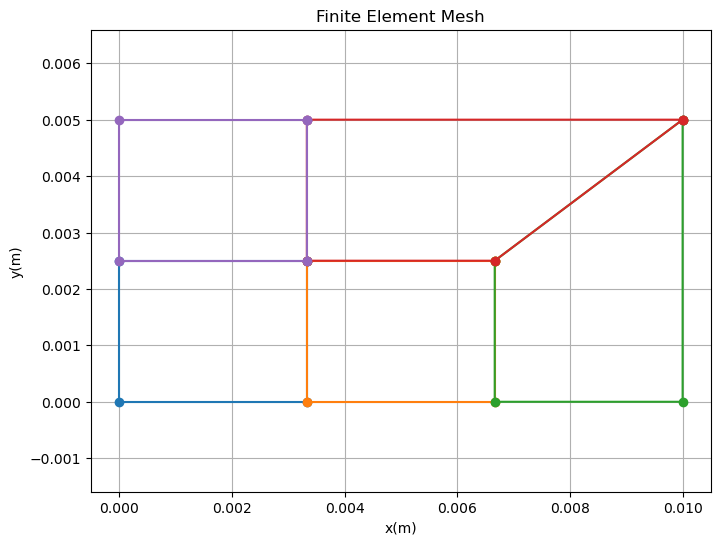

In [456]:
file_path = 'input.txt'  
mesh = Mesh(file_path)
mesh.plot_mesh()

In [457]:
element = mesh.elements[1]
k = element.localStiffnessMatrix()
np.set_printoptions(precision=1)
print(k)

[[ 5.1e+08  2.4e+08 -2.5e+08  4.8e+07 -2.5e+08 -2.4e+08 -2.3e+06 -4.8e+07]
 [ 2.4e+08  6.9e+08 -4.8e+07  2.0e+08 -2.4e+08 -3.5e+08  4.8e+07 -5.5e+08]
 [-2.5e+08 -4.8e+07  5.1e+08 -2.4e+08 -2.3e+06  4.8e+07 -2.5e+08  2.4e+08]
 [ 4.8e+07  2.0e+08 -2.4e+08  6.9e+08 -4.8e+07 -5.5e+08  2.4e+08 -3.5e+08]
 [-2.5e+08 -2.4e+08 -2.3e+06 -4.8e+07  5.1e+08  2.4e+08 -2.5e+08  4.8e+07]
 [-2.4e+08 -3.5e+08  4.8e+07 -5.5e+08  2.4e+08  6.9e+08 -4.8e+07  2.0e+08]
 [-2.3e+06  4.8e+07 -2.5e+08  2.4e+08 -2.5e+08 -4.8e+07  5.1e+08 -2.4e+08]
 [-4.8e+07 -5.5e+08  2.4e+08 -3.5e+08  4.8e+07  2.0e+08 -2.4e+08  6.9e+08]]


# Assembly

In [464]:
n_nodes = len(mesh.nodes)
#Global stiffness matrix and global load vector
K_global = np.zeros((2*n_nodes, 2*n_nodes))
R_global = np.zeros(2*n_nodes)
N_local_nodes = 4
#loop over all elements
for element in mesh.elements:
    k_local = element.localStiffnessMatrix()
    local_indices = [node.id - 1 for node in element.nodes] #adjust for zero indexing of global matrix
    local_indices = np.multiply(2,local_indices) 
    local_indices = np.concatenate([np.arange(x, x+2) for x in local_indices]) #expand the indices for 2 dof
    for i in range(2*N_local_nodes):
        for j in range(2*N_local_nodes):
            K_global[local_indices[i], local_indices[j]] += k_local[i,j]

In [465]:
print(K_global)

[[ 5.1e+08  2.4e+08 -2.5e+08  4.8e+07  0.0e+00  0.0e+00  0.0e+00  0.0e+00
   0.0e+00  0.0e+00  0.0e+00  0.0e+00 -2.5e+08 -2.4e+08 -2.3e+06 -4.8e+07
   0.0e+00  0.0e+00  0.0e+00  0.0e+00]
 [ 2.4e+08  6.9e+08 -4.8e+07  2.0e+08  0.0e+00  0.0e+00  0.0e+00  0.0e+00
   0.0e+00  0.0e+00  0.0e+00  0.0e+00 -2.4e+08 -3.5e+08  4.8e+07 -5.5e+08
   0.0e+00  0.0e+00  0.0e+00  0.0e+00]
 [-2.5e+08 -4.8e+07  1.0e+09  0.0e+00 -2.5e+08  4.8e+07  0.0e+00  0.0e+00
   0.0e+00  0.0e+00 -2.5e+08 -2.4e+08 -4.7e+06  0.0e+00 -2.5e+08  2.4e+08
   0.0e+00  0.0e+00  0.0e+00  0.0e+00]
 [ 4.8e+07  2.0e+08  0.0e+00  1.4e+09 -4.8e+07  2.0e+08  0.0e+00  0.0e+00
   0.0e+00  0.0e+00 -2.4e+08 -3.5e+08  7.5e-09 -1.1e+09  2.4e+08 -3.5e+08
   0.0e+00  0.0e+00  0.0e+00  0.0e+00]
 [ 0.0e+00  0.0e+00 -2.5e+08 -4.8e+07  1.1e+09 -1.3e+08 -4.1e+08 -7.4e+06
  -9.8e+07 -1.8e+08 -6.3e+07  1.3e+08 -2.5e+08  2.4e+08  0.0e+00  0.0e+00
   0.0e+00  0.0e+00  0.0e+00  0.0e+00]
 [ 0.0e+00  0.0e+00  4.8e+07  2.0e+08 -1.3e+08  1.3e+09 -1.0e+08 

# Boundary Conditions

In [ ]:
# #Dirchlet
# n_dirichlet_nodes = len(boundary_temperatures)
# node_ids = np.arange(0, n_nodes)
# dirchlet_node_ids =  np.array(list(boundary_temperatures.keys())) - 1  #adjust for zero indexing
# non_dirichlet_node_ids = np.setdiff1d(node_ids, dirchlet_node_ids)
# n_dirchlet_node_ids = len(dirchlet_node_ids)
# n_interior_nodes = n_nodes - n_dirchlet_node_ids
# #reducing global stiffness matrix
# reduced_K_global = np.zeros((n_interior_nodes, n_interior_nodes))
# temporary_K_global = np.delete(K_global, dirchlet_node_ids, 0) #remove rows
# reduced_K_global = np.delete(temporary_K_global, dirchlet_node_ids, 1) #remove columns 
# reduced_R_global = np.delete(R_global, dirchlet_node_ids)

# R_modifier = np.zeros(n_nodes)
# #modifying global load vector with boundary temperatures
# for node_id, temperature in boundary_temperatures.items():
#     node_id -= 1 #adjust for zero indexing
#     R_modifier += K_global[:,node_id] * temperature

# reduced_R_global -= np.delete(R_modifier, dirchlet_node_ids)

NameError: name 'boundary_temperatures' is not defined

# Solve

In [ ]:
unkown_temperatures = np.linalg.solve(reduced_K_global, reduced_R_global) #solve for unkown temperatures
#construct full temperature vector
temperature = np.zeros(n_nodes)
i = 0
for node_id in non_dirichlet_node_ids:
    temperature[node_id] = unkown_temperatures[i]
    i += 1
#add boundary temperatures to full temperature vector
for node_id, boundary_temperature in boundary_temperatures.items():
    node_id -= 1 #adjust for zero indexing
    temperature[node_id] = boundary_temperature

for node in mesh.nodes.values():
    node.setTemperature(temperature[node.id-1])

# Output

Node ID    Temperature (degC)
-------------------------
1          200            
2          200            
3          200            
4          142            
5          142            
6          142            
7          142            
8          83.3           
9          83.3           
10         83.3           
11         25             
12         25             
13         25             
14         25             


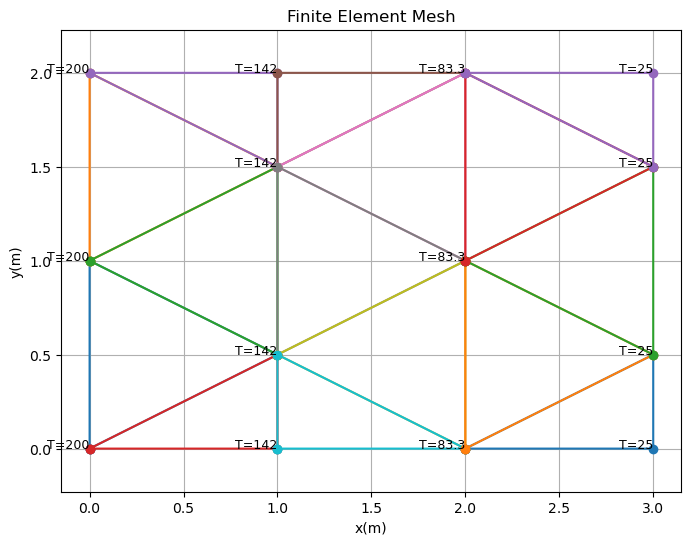

In [ ]:
print(f"{'Node ID':<10} {'Temperature (degC)':<15}")
print("-" * 25)
for node_id, node in mesh.nodes.items():
    temp_formatted = f"{mesh.nodes[node_id].T:.3g}"  # .3g for 3 significant figures
    print(f"{node_id:<10} {temp_formatted:<15}")
mesh.plot_mesh(display_temp=True)